In [3]:
import os
import pickle
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import dump

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import shap

from scipy.stats import probplot
import statsmodels.api as sm

import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Utility Functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(denom == 0, 0.0, diff / denom)
    return np.mean(ratio) * 100.0

def residual_quantile_pi(residuals: np.ndarray, alpha: float = 0.05):
    lower_q = np.quantile(residuals, alpha / 2)
    upper_q = np.quantile(residuals, 1 - alpha / 2)
    return lower_q, upper_q

def ensure_dir(path: str):
    Path(path).mkdir(parents=True, exist_ok=True)

In [5]:
# Configurations
DATA_PATH = "../data/processed/dengue_climate_all_years.csv"
MODEL_DIR = "../models"
RESULTS_DIR = "../results"
ensure_dir(MODEL_DIR)
ensure_dir(RESULTS_DIR)

LOOKBACK = 25
# Number of previous weeks of case data to include as lag features in models.
# This allows the model to learn temporal patterns and trends over roughly 6 months.

WEATHER_LAGS = [1, 2, 4, 8]
# Lags (in weeks) for weather variables to use as features.
# Example: 1-week lag = last week's weather, 2-week lag = 2 weeks ago, etc.
# Captures delayed effects of weather on case trends.

BACKTEST_STEPS = 52
# Number of weeks to simulate in backtesting.
# Typically one year of weekly forecasts to evaluate model performance.

SEED = 42
np.random.seed(SEED)

### **DATA LOADING, PREPROCESSING, AND FEATURE ENGINEERING**

**Load and Prepare Dataset**

The dengue dataset is loaded from a CSV file and standardized to use a unified temporal index. When ISO `Year` and `Week` columns are present, they are converted into a single `Date` column corresponding to the Monday of each epidemiological week using ISO week conventions. If a `Date` column already exists, it is parsed directly into datetime format. The data is then chronologically sorted and exact duplicates at the `(Barangay, Date)` level are removed to ensure a clean panel structure.

---

**Train–Test Split by Time**

To prevent temporal leakage, the dataset is split strictly by time rather than randomly. Unique dates are ordered chronologically, with the earliest 80% assigned to the training set and the remaining 20% reserved for testing. This ensures that all models are trained exclusively on historical data and evaluated only on future observations.

---

**Feature Engineering — Case Lag Creation**

Lagged dengue case features are generated on a per-barangay basis using the `create_case_lags_panel()` function. For each barangay, historical case counts are shifted by multiple lookback periods (e.g., 1-week to *n*-week lags). These lag features encode temporal autocorrelation in dengue transmission, allowing models to leverage recent outbreak dynamics when forecasting future cases.

**Feature Engineering — Weather Lag Creation**

Lagged weather variables are constructed using the `create_weather_lags_global()` function under the assumption that weather conditions are spatially uniform across barangays for a given date. Humidity, precipitation, and temperature are first deduplicated at the date level, then shifted by predefined lag intervals and merged back into the main panel. This design captures delayed meteorological effects on dengue incidence while avoiding redundant per-barangay computations.

**Encoding and Feature Assembly**

Rows containing missing values in any required lagged feature are removed to ensure model compatibility. Barangay identifiers are converted into one-hot encoded dummy variables, allowing models to learn barangay-specific baseline effects. All case lags, weather lags, and barangay indicators are concatenated into a single ordered feature set used consistently across training and evaluation.

**Final Tabular Train–Test Split**

The fully engineered dataset is partitioned once more into training and testing subsets using the original temporal boundaries. Feature matrices (`X`) and target vectors (`y`, representing dengue case counts) are then extracted, producing finalized inputs suitable for tabular machine learning models and downstream analysis.

---

**Exploratory Correlation Analysis**

To examine linear relationships between dengue cases and engineered features, a Pearson correlation analysis is performed using the fully lagged dataset. The analysis includes the target variable (`Cases`), all case lag features, and all lagged weather variables.

A correlation matrix is computed and visualized as a heatmap, centered at zero and using a diverging color scale to highlight both positive and negative associations. This visualization provides an interpretable overview of temporal autocorrelation in dengue cases as well as the delayed influence of meteorological factors, helping validate feature relevance prior to model training.

In [6]:
# Load data
df = pd.read_csv(DATA_PATH)

# If Year/Week columns exist and you want to compute Date from ISO Year-Week-Mon:
if {"Year", "Week"}.issubset(df.columns):
    df["Year"] = df["Year"].astype(int)
    df["Week"] = df["Week"].astype(int)
    # Convert ISO Year + Week -> Monday date (ISO week)
    df["Date"] = pd.to_datetime(df["Year"].astype(str) + df["Week"].astype(str) + "1", format="%G%V%u")
else:
    # Assume Date column exists
    df["Date"] = pd.to_datetime(df["Date"])

# Sort and drop exact duplicates (Barangay + Date)
df = df.sort_values(["Barangay", "Date"]).drop_duplicates(["Barangay", "Date"], keep="last").reset_index(drop=True)
print(f"[INFO] Data shape: {df.shape} ; Date range: {df['Date'].min()} → {df['Date'].max()}")

[INFO] Data shape: (29280, 9) ; Date range: 2018-01-01 00:00:00 → 2024-12-30 00:00:00


In [7]:
# Train/test split (time-based)
unique_dates = sorted(df["Date"].unique())
cut = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:cut]
test_dates = unique_dates[cut:]

train_df = df[df["Date"].isin(train_dates)].copy()
test_df = df[df["Date"].isin(test_dates)].copy()

print(f"[INFO] Train date range: {train_df['Date'].min()} → {train_df['Date'].max()}")
print(f"[INFO] Test date range: {test_df['Date'].min()} → {test_df['Date'].max()}")

[INFO] Train date range: 2018-01-01 00:00:00 → 2023-07-31 00:00:00
[INFO] Test date range: 2023-08-07 00:00:00 → 2024-12-30 00:00:00


In [8]:
# Feature engineering
def create_case_lags_panel(df_in: pd.DataFrame, lags: List[int]) -> pd.DataFrame:
    """Create case lag columns per barangay efficiently."""
    out = []
    for b, g in df_in.groupby("Barangay", sort=False):
        g = g.sort_values("Date").copy()
        for lag in lags:
            g[f"Cases_lag{lag}"] = g["Cases"].shift(lag)
        out.append(g)
    return pd.concat(out, ignore_index=True)


def create_weather_lags_global(df_in: pd.DataFrame, weather_cols: List[str], lags: List[int]) -> pd.DataFrame:
    """
    Create lagged weather columns using the unique daily weather (assumes weather is global per date).
    Returns the original df merged with weather lagged columns.
    """
    weather_daily = df_in[["Date"] + weather_cols].drop_duplicates("Date").set_index("Date").sort_index()
    for col in weather_cols:
        for lag in lags:
            weather_daily[f"{col}_lag{lag}"] = weather_daily[col].shift(lag)
    # drop original weather cols from the lagged table (optional: keep if you want)
    weather_lagged = weather_daily[[c for c in weather_daily.columns if any(col in c for col in weather_cols)]].copy()
    # actually choose columns with _lag in name
    weather_lagged = weather_daily[[c for c in weather_daily.columns if "_lag" in c]]
    weather_lagged = weather_lagged.reset_index()
    # merge once to main df
    df_merged = df_in.merge(weather_lagged, on="Date", how="left")
    return df_merged


WEATHER_COLS = ["Humidity", "Precipitation", "Temperature"]
LAGS = list(range(1, LOOKBACK + 1))

# Create case lags
df_lagged = create_case_lags_panel(df, lags=LAGS)

# Add weather lags (global by date)
df_lagged = create_weather_lags_global(df_lagged, weather_cols=WEATHER_COLS, lags=WEATHER_LAGS)

# Drop rows with any remaining NaNs in the required lag columns
required_cols = [f"Cases_lag{l}" for l in LAGS] + [f"{w}_lag{lag}" for w in WEATHER_COLS for lag in WEATHER_LAGS]
df_lagged = df_lagged.dropna(subset=required_cols).reset_index(drop=True)

# One-hot encode barangay dummies (drop_first avoids collinearity)
df_lagged = pd.get_dummies(df_lagged, columns=["Barangay"], drop_first=False)
barangay_dummy_cols = [c for c in df_lagged.columns if c.startswith("Barangay_")]

# Compose feature column list (maintain order used in training)
lag_cols = [f"Cases_lag{l}" for l in LAGS]
weather_lag_cols = [f"{w}_lag{lag}" for w in WEATHER_COLS for lag in WEATHER_LAGS]
feature_cols = lag_cols + weather_lag_cols + barangay_dummy_cols
target_col = "Cases"

# Final drop of rows with NaN in features (already done above but safe)
df_lagged = df_lagged.dropna(subset=feature_cols + [target_col]).copy()

# Train/test split for tabular models
train_tab = df_lagged[df_lagged["Date"].isin(train_dates)].copy()
test_tab = df_lagged[df_lagged["Date"].isin(test_dates)].copy()

X_train_tab = train_tab[feature_cols]
y_train_tab = train_tab[target_col]
X_test_tab = test_tab[feature_cols]
y_test_tab = test_tab[target_col]

print(f"[INFO] Tabular train shape: {X_train_tab.shape} ; test shape: {X_test_tab.shape}")

[INFO] Tabular train shape: (21360, 117) ; test shape: (5920, 117)


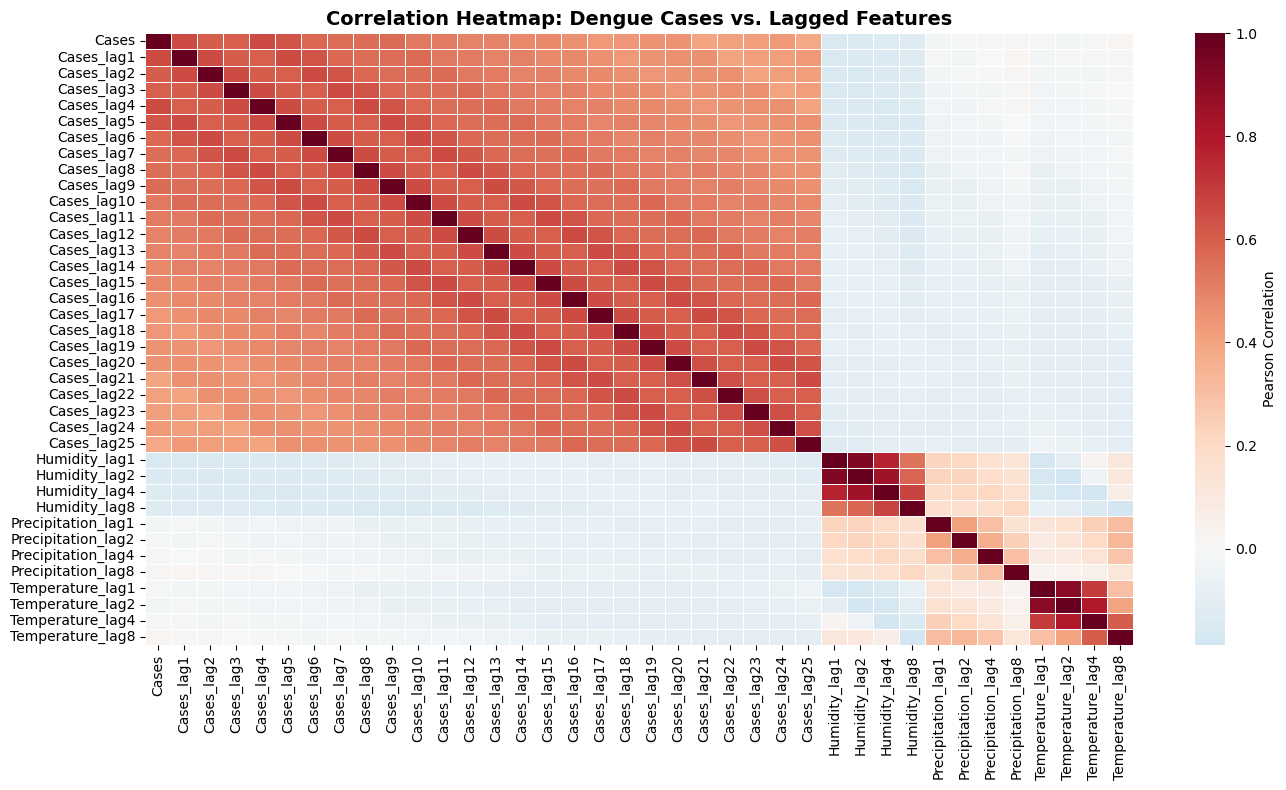

In [9]:
# Select relevant columns for correlation (target + lags)
corr_cols = ["Cases"] + lag_cols + weather_lag_cols
corr_df = df_lagged[corr_cols].copy()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    corr_matrix,
    cmap="RdBu_r",
    center=0,
    annot=False,
    linewidths=0.5,
    cbar_kws={"label": "Pearson Correlation"}
)
plt.title("Correlation Heatmap: Dengue Cases vs. Lagged Features", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

### **MODEL TRAINING**

**Data Standardization for Linear Regression**

Because Linear Regression is sensitive to feature scale, input features are standardized using a `StandardScaler`. The scaler is fitted exclusively on the training data and then applied to both training and test sets to prevent data leakage. This standardized representation is used only for the linear baseline model, while tree-based and neural models operate on the original feature scales.

---

**Baseline Linear Regression Training**

A standard Linear Regression model is trained as a baseline for dengue case forecasting using the standardized lag-based feature set. This model provides a simple linear benchmark against which more complex models can be compared. Training residuals are also computed to support subsequent error analysis.

---

**Random Forest Model Training and Interpretation**

A Random Forest Regressor is trained next to capture non-linear relationships and feature interactions among dengue case lags, lagged weather variables, and barangay indicators. Model hyperparameters—including tree depth, number of estimators, and feature subsampling strategy—are optimized using randomized search with three-fold cross-validation and mean squared error as the objective metric.

To improve interpretability, SHAP (SHapley Additive exPlanations) values are computed on a representative subset of the training data. Mean absolute SHAP values are used to rank feature importance, and the top ten most influential features are visualized, providing insight into the dominant temporal and environmental drivers learned by the model.

---

**XGBoost Model Training and Feature Importance Analysis**

An XGBoost regressor is trained using gradient boosting with decision trees, offering strong performance on structured tabular data. A randomized hyperparameter search is conducted to tune learning rate, tree depth, regularization terms, and subsampling ratios. The best-performing configuration is selected based on cross-validated mean squared error.

Feature importance is subsequently extracted from the trained booster using gain-based importance scores. The top ten features are visualized to highlight which lagged case counts, weather variables, or barangay indicators contribute most to predictive performance.

---

**Sequential Data Construction for LSTM Modeling**

Unlike tabular models, the LSTM requires explicitly ordered temporal sequences. The engineered lag features are therefore transformed into true time-series sequences using a sliding window approach. For each barangay, historical observations are grouped and sorted chronologically, then segmented into fixed-length windows of `LOOKBACK` weeks.

Dynamic features—comprising lagged dengue cases and lagged weather variables—form the time-varying inputs, while barangay one-hot encodings are treated as static features and repeated across all timesteps. This results in a three-dimensional input tensor with shape:

**(samples, timesteps, features per timestep)**

This design allows the LSTM to jointly learn temporal dynamics and barangay-specific effects.

---

**LSTM Model Training**

A Long Short-Term Memory (LSTM) neural network is trained to model long-range temporal dependencies in dengue transmission. The architecture consists of a single LSTM layer followed by dropout for regularization and fully connected layers for regression output. The model is optimized using the Adam optimizer with mean squared error as the loss function.

Training is performed over multiple epochs with a held-out validation split from the training data, enabling the model to learn patterns across historical dengue incidence, delayed weather effects, and persistent spatial characteristics.

**LINEAR REGRESSION**

In [10]:
# Standardize only for linear regression
scaler_tab = StandardScaler()
X_train_scaled = scaler_tab.fit_transform(X_train_tab)
X_test_scaled = scaler_tab.transform(X_test_tab)

# Linear Regression (Baseline)
print("[INFO] Training Linear Regression ...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_tab)
lr_resid = y_train_tab.values - lr_model.predict(X_train_scaled)

[INFO] Training Linear Regression ...


**RANDOM FOREST REGRESSOR**

In [11]:
# Random Forest
print("[INFO] Training Random Forest ...")
rf_base = RandomForestRegressor(random_state=SEED, n_jobs=-1)

rf_param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    rf_base,
    rf_param_grid,
    n_iter=30,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=SEED,
    n_jobs=-1,
    verbose=0
)

rf_search.fit(X_train_tab, y_train_tab)
rf_model = rf_search.best_estimator_

print(f"[INFO] Best Random Forest params: {rf_search.best_params_}")
rf_resid = y_train_tab.values - rf_model.predict(X_train_tab)

[INFO] Training Random Forest ...
[INFO] Best Random Forest params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


[INFO] Computing SHAP values for Random Forest ...


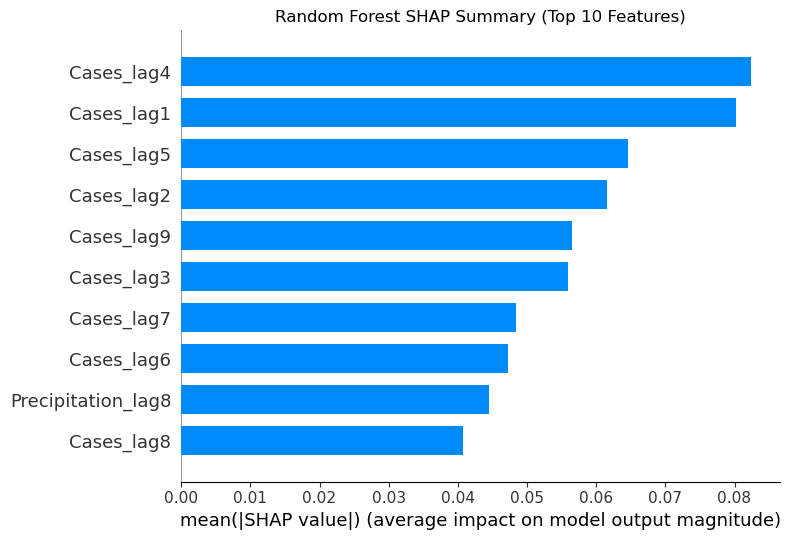

In [12]:
# Random Forest SHAP (Top 10 Features)
print("[INFO] Computing SHAP values for Random Forest ...")

X_sample = X_train_tab.sample(n=min(500, len(X_train_tab)), random_state=SEED).astype(float)
explainer_rf = shap.TreeExplainer(rf_model, feature_perturbation="interventional")
shap_values_rf = explainer_rf.shap_values(X_sample, check_additivity=False)

# Get top 10 features by mean absolute SHAP value
shap_importance = np.abs(shap_values_rf).mean(axis=0)
top_idx = np.argsort(shap_importance)[-10:][::-1]
top_features = X_sample.columns[top_idx]

# Plot top 10 SHAP features
plt.figure(figsize=(10, 6))
plt.title("Random Forest SHAP Summary (Top 10 Features)")
shap.summary_plot(
    shap_values_rf[:, top_idx],
    X_sample[top_features],
    plot_type="bar",
    show=False
)
plt.tight_layout()
output_path = os.path.join(RESULTS_DIR, "rf_shap_summary_top10.png")
plt.savefig(output_path, dpi=300)
plt.show()

**XGBOOST REGRESSOR**

In [13]:
# XGBoost
print("[INFO] Training XGBoost ...")
xgb_base = XGBRegressor(random_state=SEED, objective="reg:squarederror", verbosity=0, n_jobs=-1)

xgb_param_grid = {
    "n_estimators": [200, 300, 400, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.1, 0.5, 1, 2]
}

xgb_search = RandomizedSearchCV(
    xgb_base,
    xgb_param_grid,
    n_iter=40,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=SEED,
    n_jobs=-1,
    verbose=0
)

xgb_search.fit(X_train_tab, y_train_tab)
xgb_model = xgb_search.best_estimator_

print(f"[INFO] Best XGBoost params: {xgb_search.best_params_}")
xgb_resid = y_train_tab.values - xgb_model.predict(X_train_tab)

[INFO] Training XGBoost ...
[INFO] Best XGBoost params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


[INFO] Extracting XGBoost feature importance ...


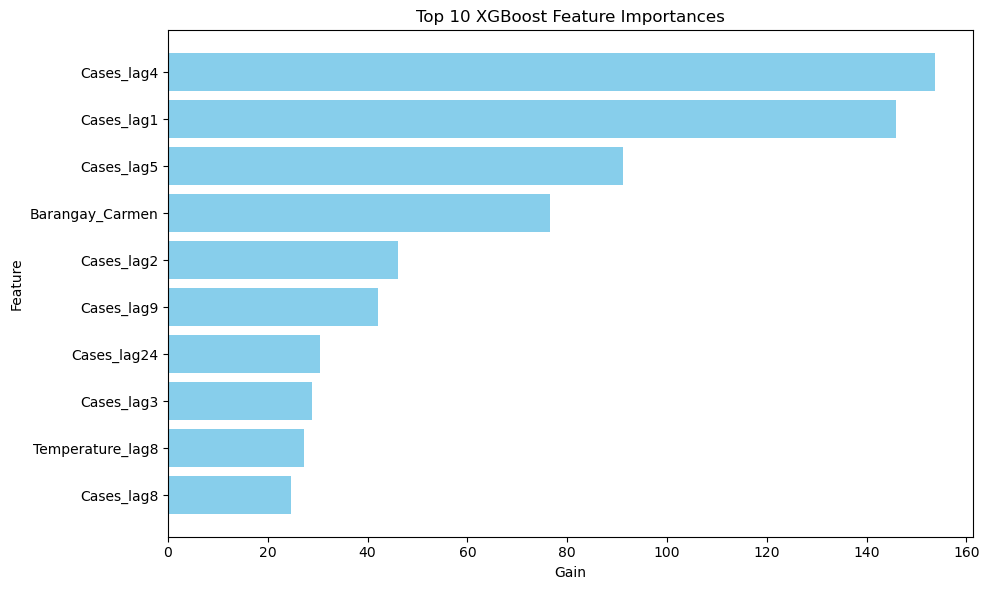

In [14]:
# XGBoost Feature Importance (Top 10)
print("[INFO] Extracting XGBoost feature importance ...")

booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='gain')

# Create DataFrame of top 10 features
importance_df = (
    pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending=False)
    .head(10)
)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1], color='skyblue')
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.title("Top 10 XGBoost Feature Importances")
plt.tight_layout()
output_path = os.path.join(RESULTS_DIR, "xgb_feature_importance_top10.png")
plt.savefig(output_path, dpi=300)
plt.show()

**LSTM**

In [15]:
# Build sequences for LSTM from lag features
def to_lstm_sequence(df, lookback, lag_cols, weather_lag_cols, barangay_cols, target_col):
    """
    Build true LSTM sequences even when the Barangay column has been one-hot encoded.
    We reconstruct barangay groups using dummy columns.
    """

    sequences_X = []
    sequences_y = []

    # Identify barangay of each row based on which dummy column = 1
    df = df.copy()
    df["__Barangay"] = df[barangay_cols].idxmax(axis=1)

    # Determine timestep features (lags only)
    timestep_features = len(lag_cols) + len(weather_lag_cols)

    for barangay_name, g in df.groupby("__Barangay", sort=False):
        g_sorted = g.sort_values("Date")

        # lag features
        X_lag = g_sorted[lag_cols + weather_lag_cols].values
        
        # static barangay dummy vector
        X_static = g_sorted[barangay_cols].values
        
        # target
        y = g_sorted[target_col].values

        # Sliding windows
        for i in range(lookback, len(g_sorted)):
            seq_lag = X_lag[i - lookback:i].reshape(lookback, timestep_features)

            # repeat barangay static vector across timesteps
            seq_static = np.repeat(X_static[i].reshape(1, -1), lookback, axis=0)

            # combine dynamic + static
            seq = np.concatenate([seq_lag, seq_static], axis=1)

            sequences_X.append(seq)
            sequences_y.append(y[i])

    X = np.array(sequences_X)
    y = np.array(sequences_y)

    return X, y


# Build LSTM datasets
X_train_lstm, y_train_lstm = to_lstm_sequence(
    train_tab,
    lookback=LOOKBACK,
    lag_cols=lag_cols,
    weather_lag_cols=weather_lag_cols,
    barangay_cols=barangay_dummy_cols,
    target_col=target_col
)

X_test_lstm, y_test_lstm = to_lstm_sequence(
    test_tab,
    lookback=LOOKBACK,
    lag_cols=lag_cols,
    weather_lag_cols=weather_lag_cols,
    barangay_cols=barangay_dummy_cols,
    target_col=target_col
)

print("LSTM train shape:", X_train_lstm.shape)
print("LSTM test shape:", X_test_lstm.shape)


# Define LSTM Model
n_timesteps = X_train_lstm.shape[1]
n_features = X_train_lstm.shape[2]

lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # regression output
])

lstm_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)


# Train LSTM model
print("[INFO] Training LSTM ...")
lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=0
)

LSTM train shape: (19360, 25, 117)
LSTM test shape: (3920, 25, 117)
[INFO] Training LSTM ...


### **BACKTESTING / RECURSIVE FORECASTS**

**Setup for Backtesting**

Defines the backtest period (`BACKTEST_STEPS` weeks) using the most recent portion of `test_df`. Constructs a dictionary (`grp_hist`) containing historical per-barangay DataFrames indexed by date, which serve as the starting point for recursive forecasting.

---

**LSTM Global Forecast**

Implements a global Long Short-Term Memory (LSTM) model trained on the full dengue dataset, using lagged dengue cases, lagged weather variables, and one-hot encoded barangay identifiers as inputs.

For each barangay, a recursive multi-step backtesting procedure is applied:

* A fixed-length historical window (`lookback`) is extracted from the most recent observations.
* Lagged dengue and weather features are updated at each step using the latest observed or previously predicted values.
* Barangay identity is encoded via static dummy variables, enabling a single global LSTM to capture shared temporal dynamics while retaining barangay-specific behavior.
* The LSTM produces one-step-ahead predictions, which are iteratively fed back into the historical sequence to generate forecasts across the backtest horizon.

Forecasts are generated independently for each barangay and aggregated into a unified forecast matrix (dates × barangays).
No parametric prediction intervals are produced for the LSTM; uncertainty is assessed indirectly through backtest error metrics and downstream risk scoring.

---

**Recursive Forecasts for Tabular Models**

Runs per-barangay recursive backtests for:

* Linear Regression (LR)
* Random Forest (RF)
* XGBoost (XGB)

Each model follows a recursive forecasting strategy:

* Lagged dengue cases and weather variables are updated at every timestep.
* Barangay dummy variables are applied to preserve spatial identity where required.
* Exogenous weather inputs (Humidity, Precipitation, Temperature) are incorporated when available.
* Predictions are generated sequentially, with each forecast feeding into the next step.

---

**Evaluation Metrics**

For each model, per-barangay performance metrics are computed over the backtest horizon:

* Mean Absolute Error (MAE)
* Mean Squared Error (MSE)
* Root Mean Squared Error (RMSE)
* Symmetric Mean Absolute Percentage Error (sMAPE)
* Coefficient of Determination (R²)

Average metrics across barangays are then summarized for comparative evaluation.

---

**Prediction Interval (PI) Coverage**

* For tabular models, empirical prediction intervals are constructed using residual-based quantile estimates derived from training residuals (`lr_resid`, `rf_resid`, `xgb_resid`).
* Coverage is computed as the proportion of observed dengue cases falling within the estimated 95% prediction intervals.
* The LSTM model does not produce analytical prediction intervals; PI coverage is therefore not reported for this model.

---

**Summary Report**

Generates and saves `model_performance_summary.csv`, which reports average MAE, MSE, RMSE, sMAPE, R², and (where applicable) 95% prediction interval coverage for each model.

---

**Visualization**

Produces comparative plots for a representative barangay showing:

* Observed dengue case counts
* Backtest forecasts from LSTM, LR, RF, and XGB
* Shaded prediction intervals for tabular models

In [16]:
print(f"[INFO] Running backtest for last {BACKTEST_STEPS} weeks ...")
test_dates_sorted = sorted(test_df["Date"].unique())
backtest_dates = test_dates_sorted[-BACKTEST_STEPS:]

# Build per-barangay historical DataFrames (index = Date)
grp_hist = {}
for b, g in df.groupby("Barangay", sort=False):
    g_sorted = g.sort_values("Date").set_index("Date").copy()
    grp_hist[b] = g_sorted

barangays = list(grp_hist.keys())


# LSTM helper: build sequence
def build_lstm_input_sequence(hist_df, lookback, lag_cols, weather_lag_cols, barangay_dummy_cols):
    required_cols = lag_cols + weather_lag_cols + barangay_dummy_cols
    seq = hist_df[required_cols].iloc[-lookback:].values
    seq = seq.reshape(1, lookback, len(required_cols))
    return seq


# Recursive LSTM forecast
def recursive_lstm_forecast(
    model,
    start_hist: pd.DataFrame,
    future_dates,
    lookback,
    lag_cols,
    weather_lag_cols,
    barangay_dummy_cols,
    weather_cols=WEATHER_COLS
):
    hist = start_hist.copy()
    preds = []

    for dt in future_dates:

        # Update lag columns
        for lag in LAGS:
            hist[f"Cases_lag{lag}"] = hist["Cases"].shift(lag)

        for w in weather_cols:
            for lag in WEATHER_LAGS:
                hist[f"{w}_lag{lag}"] = hist[w].shift(lag)

        hist = hist.fillna(method="ffill").fillna(0)

        # Build sequence for LSTM
        X_seq = build_lstm_input_sequence(
            hist, lookback, lag_cols, weather_lag_cols, barangay_dummy_cols
        )

        # 1-step prediction
        pred_val = float(model.predict(X_seq, verbose=0)[0][0])
        pred_val = max(0.0, pred_val)
        preds.append(pred_val)

        # Update historical df for next step
        new_row = hist.iloc[-1].copy()
        new_row["Cases"] = pred_val
        new_row.name = dt
        hist.loc[dt] = new_row

    return pd.Series(preds, index=future_dates)


print("[INFO] LSTM backtest forecast (global) ...")

lstm_forecasts = []

for b in barangays:
    hist = grp_hist[b].copy()

    # Add barangay dummy columns
    for col in barangay_dummy_cols:
        hist[col] = 0.0
    correct_dummy = f"Barangay_{b}"
    if correct_dummy in barangay_dummy_cols:
        hist[correct_dummy] = 1.0
    else:
        print(f"[WARN] Dummy column missing for barangay: {b}")

    # Ensure minimal lag columns
    for lag in LAGS:
        hist[f"Cases_lag{lag}"] = hist["Cases"].shift(lag)
    for w in WEATHER_COLS:
        for lag in WEATHER_LAGS:
            hist[f"{w}_lag{lag}"] = hist[w].shift(lag)

    hist = hist.fillna(method="ffill").fillna(0)

    try:
        s = recursive_lstm_forecast(
            model=lstm_model,
            start_hist=hist,
            future_dates=backtest_dates,
            lookback=LOOKBACK,
            lag_cols=lag_cols,
            weather_lag_cols=weather_lag_cols,
            barangay_dummy_cols=barangay_dummy_cols,
            weather_cols=WEATHER_COLS
        )
        s.name = b
        lstm_forecasts.append(s)

    except Exception as e:
        print(f"[WARN] LSTM recursive forecast failed for barangay {b}: {e}")


# Combine per-barangay into DataFrame
if len(lstm_forecasts) == 0:
    lstm_forecast_df = pd.DataFrame(index=backtest_dates, columns=barangays).fillna(0.0)
else:
    lstm_forecast_df = pd.concat(lstm_forecasts, axis=1)
    lstm_forecast_df.columns = [s.name for s in lstm_forecasts]
    lstm_forecast_df = lstm_forecast_df.reindex(columns=barangays).fillna(0.0)

print("[INFO] LSTM backtest complete")


# Recursive tabular forecast per barangay (LR, RF, XGB)
def recursive_tabular_forecast(
    model,
    model_name: str,
    start_hist: pd.DataFrame,
    future_dates: List[pd.Timestamp],
    lags: List[int],
    weather_lags: List[int],
    feature_cols: List[str],
    scaler_for_lr: StandardScaler = None,
    test_df_for_exog: pd.DataFrame = None,
    barangay_dummy_cols: List[str] = None,
    stochastic_std: float = 0.1,  # fraction of predicted value
    random_state: int = None,
) -> pd.Series:
    """
    Recursive forecast with optional stochastic noise to prevent flat predictions.

    Args:
        model: trained model (LR, RF, XGB, etc.)
        model_name: string name of model ('LinearRegression', 'RandomForest', 'XGBoost')
        start_hist: historical DataFrame indexed by Date, must include 'Cases', weather columns, and lag columns if present
        future_dates: list of future timestamps to forecast
        lags: list of integer lags for Cases
        weather_lags: list of integer lags for weather variables
        feature_cols: columns used during training
        scaler_for_lr: StandardScaler used for LinearRegression, if any
        test_df_for_exog: DataFrame with exogenous weather variables for future dates
        barangay_dummy_cols: list of dummy columns for barangay encoding
        stochastic_std: relative noise (0.1 = 10% of predicted value)
        random_state: seed for reproducible noise
    Returns:
        pd.Series of predicted cases indexed by future_dates
    """
    rng = np.random.default_rng(random_state)
    weather_vars = WEATHER_COLS
    hist = start_hist.copy()

    # Ensure lag columns exist
    for lag in lags:
        hist[f"Cases_lag{lag}"] = hist["Cases"].shift(lag)
    for w in weather_vars:
        for lag in weather_lags:
            hist[f"{w}_lag{lag}"] = hist[w].shift(lag)
    hist = hist.fillna(0)

    last = hist.iloc[-1].copy()
    preds = []

    for dt in future_dates:
        # Exogenous weather
        if test_df_for_exog is not None:
            tmp = test_df_for_exog[
                (test_df_for_exog["Date"] == dt) &
                (test_df_for_exog["Barangay"] == last["Barangay"])
            ]
            if len(tmp):
                ex_row = tmp.iloc[0]
                hum, pre, temp = float(ex_row["Humidity"]), float(ex_row["Precipitation"]), float(ex_row["Temperature"])
            else:
                hum = float(last.get("Humidity", 0.0))
                pre = float(last.get("Precipitation", 0.0))
                temp = float(last.get("Temperature", 0.0))
        else:
            hum = float(last.get("Humidity", 0.0))
            pre = float(last.get("Precipitation", 0.0))
            temp = float(last.get("Temperature", 0.0))

        # Update case lags
        for k in reversed(lags):
            last[f"Cases_lag{k}"] = last.get(f"Cases_lag{k-1}", 0.0) if k > 1 else last.get("Cases", 0.0)

        # Update weather lags
        for wv, cur in zip(weather_vars, [hum, pre, temp]):
            for k in reversed(weather_lags):
                last[f"{wv}_lag{k}"] = last.get(f"{wv}_lag{k-1}", 0.0) if k > 1 else cur

        # Build feature vector
        feat = {c: last.get(c, 0.0) for c in feature_cols}

        # Set barangay dummies if provided
        if barangay_dummy_cols:
            bname = last["Barangay"]
            dummy_col = f"Barangay_{bname}"
            for d in barangay_dummy_cols:
                feat[d] = 1.0 if d == dummy_col else 0.0

        X_row = pd.DataFrame([feat], columns=feature_cols).fillna(0)

        # LinearRegression scaling
        X_in = scaler_for_lr.transform(X_row) if (model_name == "LinearRegression" and scaler_for_lr is not None) else X_row.values

        # Predict
        pred = float(model.predict(X_in)[0])
        pred = max(0.0, pred)  # ensure non-negative

        # Add stochastic noise
        noise = rng.normal(0, stochastic_std * max(1.0, pred))
        pred_noisy = max(0.0, pred + noise)

        preds.append(pred_noisy)

        # Update last row
        last["Cases"] = pred_noisy
        last["Humidity"] = hum
        last["Precipitation"] = pre
        last["Temperature"] = temp

    return pd.Series(preds, index=future_dates)


# Run recursive forecasts for each barangay and each tabular model
models_to_run = {
    "LinearRegression": (lr_model, True),
    "RandomForest": (rf_model, False),
    "XGBoost": (xgb_model, False),
}

tabular_forecasts: Dict[str, List[pd.Series]] = {m: [] for m in models_to_run}

print(f"[INFO] LR, RF, and XGB backtest forecast ...")
for b in barangays:
    hist = grp_hist[b].copy()
    # make sure minimal columns exist
    for lag in LAGS:
        hist[f"Cases_lag{lag}"] = hist["Cases"].shift(lag)
    for w in WEATHER_COLS:
        for lag in WEATHER_LAGS:
            hist[f"{w}_lag{lag}"] = hist[w].shift(lag)
    hist = hist.fillna(0)

    for mname, (mdl, scaled_flag) in models_to_run.items():
        try:
            s = recursive_tabular_forecast(
                model=mdl,
                model_name=mname,
                start_hist=hist,
                future_dates=backtest_dates,
                lags=LAGS,
                weather_lags=WEATHER_LAGS,
                feature_cols=feature_cols,
                scaler_for_lr=(scaler_tab if scaled_flag else None),
                test_df_for_exog=test_df,
                barangay_dummy_cols=barangay_dummy_cols,
                stochastic_std=0,
                random_state=SEED
            )
            s.name = b
            tabular_forecasts[mname].append(s)
        except Exception as e:
            print(f"[WARN] recursive forecast failed for barangay {b} model {mname}: {e}")

# Combine per-model forecasts into DataFrames (dates x barangays)
tabular_forecast_dfs = {}
for mname, series_list in tabular_forecasts.items():
    if len(series_list) == 0:
        tabular_forecast_dfs[mname] = pd.DataFrame(index=backtest_dates, columns=barangays).fillna(0.0)
    else:
        dfm = pd.concat(series_list, axis=1)
        dfm.columns = [s.name for s in series_list]
        dfm = dfm.reindex(columns=barangays).fillna(0.0)
        tabular_forecast_dfs[mname] = dfm

[INFO] Running backtest for last 52 weeks ...
[INFO] LSTM backtest forecast (global) ...
[INFO] LSTM backtest complete
[INFO] LR, RF, and XGB backtest forecast ...


In [17]:
# Evaluation
print("[INFO] Evaluating forecasts ...")

# Actuals pivot (dates x barangays) for backtest dates
actuals_pivot = df.pivot_table(index="Date", columns="Barangay", values="Cases", aggfunc="mean").reindex(backtest_dates).fillna(0.0)
actuals_pivot = actuals_pivot.reindex(columns=barangays).fillna(0.0)


def compute_metrics_per_barangay(true_df: pd.DataFrame, pred_df: pd.DataFrame):
    rows = []
    for b in true_df.columns:
        y_true = true_df[b].values
        y_pred = pred_df[b].values
        rows.append({
            "Barangay": b,
            "MAE": mean_absolute_error(y_true, y_pred),
            "MSE": mean_squared_error(y_true, y_pred),
            "RMSE": rmse(y_true, y_pred),
            "sMAPE": smape(y_true, y_pred),
            "R2": r2_score(y_true, y_pred),
        })
    return pd.DataFrame(rows)


# LSTM metrics
metrics_lstm = compute_metrics_per_barangay(
    actuals_pivot, 
    lstm_forecast_df.reindex(columns=barangays).fillna(0.0)
)
metrics_lstm_avg = metrics_lstm.mean(numeric_only=True).to_dict()

# Tabular metrics
metrics_store = {}
for mname in tabular_forecast_dfs:
    metrics_df = compute_metrics_per_barangay(actuals_pivot, tabular_forecast_dfs[mname])
    metrics_store[mname] = metrics_df

metrics_lr_avg = metrics_store["LinearRegression"].mean(numeric_only=True).to_dict()
metrics_rf_avg = metrics_store["RandomForest"].mean(numeric_only=True).to_dict()
metrics_xgb_avg = metrics_store["XGBoost"].mean(numeric_only=True).to_dict()

# Prediction interval (empirical/residual-based) coverage
alpha = 0.05
lstm_cov = np.nan # LSTM currently has no PI

lr_lq, lr_uq = residual_quantile_pi(lr_resid, alpha=alpha)
lr_lower_df = tabular_forecast_dfs["LinearRegression"] + lr_lq
lr_upper_df = tabular_forecast_dfs["LinearRegression"] + lr_uq
lr_cov = ((actuals_pivot >= lr_lower_df) & (actuals_pivot <= lr_upper_df)).values.sum() / np.prod(actuals_pivot.shape) * 100

rf_lq, rf_uq = residual_quantile_pi(rf_resid, alpha=alpha)
rf_lower_df = tabular_forecast_dfs["RandomForest"] + rf_lq
rf_upper_df = tabular_forecast_dfs["RandomForest"] + rf_uq
rf_cov = ((actuals_pivot >= rf_lower_df) & (actuals_pivot <= rf_upper_df)).values.sum() / np.prod(actuals_pivot.shape) * 100

xgb_lq, xgb_uq = residual_quantile_pi(xgb_resid, alpha=alpha)
xgb_lower_df = tabular_forecast_dfs["XGBoost"] + xgb_lq
xgb_upper_df = tabular_forecast_dfs["XGBoost"] + xgb_uq
xgb_cov = ((actuals_pivot >= xgb_lower_df) & (actuals_pivot <= xgb_upper_df)).values.sum() / np.prod(actuals_pivot.shape) * 100

# Summary DataFrame
summary = pd.DataFrame([
    {
        "Model": "LSTM",
        "MAE_avg": metrics_lstm_avg["MAE"],
        "MSE_avg": metrics_lstm_avg["MSE"],
        "RMSE_avg": metrics_lstm_avg["RMSE"],
        "sMAPE_avg": metrics_lstm_avg["sMAPE"],
        "R2_avg": metrics_lstm_avg["R2"],
        "PI_Coverage(95%)": lstm_cov
    },
    {
        "Model": "LinearRegression",
        "MAE_avg": metrics_lr_avg["MAE"],
        "MSE_avg": metrics_lr_avg["MSE"],
        "RMSE_avg": metrics_lr_avg["RMSE"],
        "sMAPE_avg": metrics_lr_avg["sMAPE"],
        "R2_avg": metrics_lr_avg["R2"],
        "PI_Coverage(95%)": lr_cov
    },
    {
        "Model": "RandomForest",
        "MAE_avg": metrics_rf_avg["MAE"],
        "MSE_avg": metrics_rf_avg["MSE"],
        "RMSE_avg": metrics_rf_avg["RMSE"],
        "sMAPE_avg": metrics_rf_avg["sMAPE"],
        "R2_avg": metrics_rf_avg["R2"],
        "PI_Coverage(95%)": rf_cov
    },
    {
        "Model": "XGBoost",
        "MAE_avg": metrics_xgb_avg["MAE"],
        "MSE_avg": metrics_xgb_avg["MSE"],
        "RMSE_avg": metrics_xgb_avg["RMSE"],
        "sMAPE_avg": metrics_xgb_avg["sMAPE"],
        "R2_avg": metrics_xgb_avg["R2"],
        "PI_Coverage(95%)": xgb_cov
    },
])

summary = summary.round(4)
summary_path = os.path.join(RESULTS_DIR, "model_performance_summary.csv")
summary.to_csv(summary_path, index=False)
print("[INFO] Summary saved to", summary_path)
display(summary)

[INFO] Evaluating forecasts ...
[INFO] Summary saved to ../results\model_performance_summary.csv


,Model,MAE_avg,MSE_avg,RMSE_avg,sMAPE_avg,R2_avg,PI_Coverage(95%)
0,LSTM,0.4616,1.0269,0.6146,177.5657,-0.2122,NaN
1,LinearRegression,0.4139,1.6692,0.6966,39.2788,-0.0197,95.3365
2,RandomForest,0.3815,0.9238,0.5676,175.0085,-0.0654,84.3269
3,XGBoost,0.3877,1.3563,0.6502,166.2772,-0.1775,91.5625


[INFO] Figure saved to ../results/backtest_Agusan.png


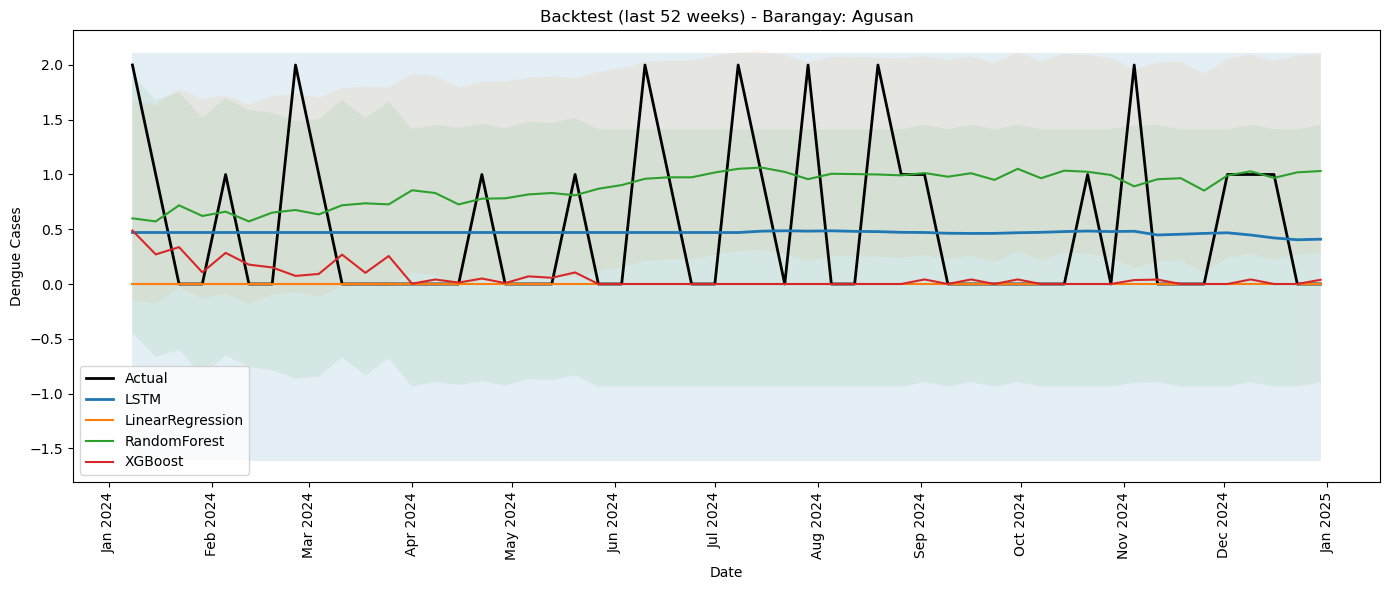

In [18]:
# Plot example barangay
plot_bgy = "Agusan"
if plot_bgy:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(actuals_pivot.index, actuals_pivot[plot_bgy], label="Actual", linewidth=2, linestyle="-", color="black")
    
    # LSTM
    ax.plot(lstm_forecast_df.index, lstm_forecast_df[plot_bgy], label="LSTM", linewidth=2)
    
    # LR
    ax.plot(tabular_forecast_dfs["LinearRegression"].index, tabular_forecast_dfs["LinearRegression"][plot_bgy], label="LinearRegression", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["LinearRegression"].index,
                    lr_lower_df[plot_bgy], lr_upper_df[plot_bgy], alpha=0.12)
    
    # RF
    ax.plot(tabular_forecast_dfs["RandomForest"].index, tabular_forecast_dfs["RandomForest"][plot_bgy], label="RandomForest", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["RandomForest"].index,
                    rf_lower_df[plot_bgy], rf_upper_df[plot_bgy], alpha=0.08)
    
    # XGB
    ax.plot(tabular_forecast_dfs["XGBoost"].index, tabular_forecast_dfs["XGBoost"][plot_bgy], label="XGBoost", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["XGBoost"].index,
                    xgb_lower_df[plot_bgy], xgb_upper_df[plot_bgy], alpha=0.08)

    ax.set_title(f"Backtest (last {BACKTEST_STEPS} weeks) - Barangay: {plot_bgy}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Dengue Cases")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.xticks(rotation=90)
    ax.legend()
    plt.tight_layout()

    # Save the figure
    save_path = f"../results/backtest_{plot_bgy}.png"
    fig.savefig(save_path, dpi=300)
    print(f"[INFO] Figure saved to {save_path}")
    
    plt.show()
else:
    print("[WARN] No barangay to plot.")

[INFO] Figure saved to ../results/backtest_Balulang.png


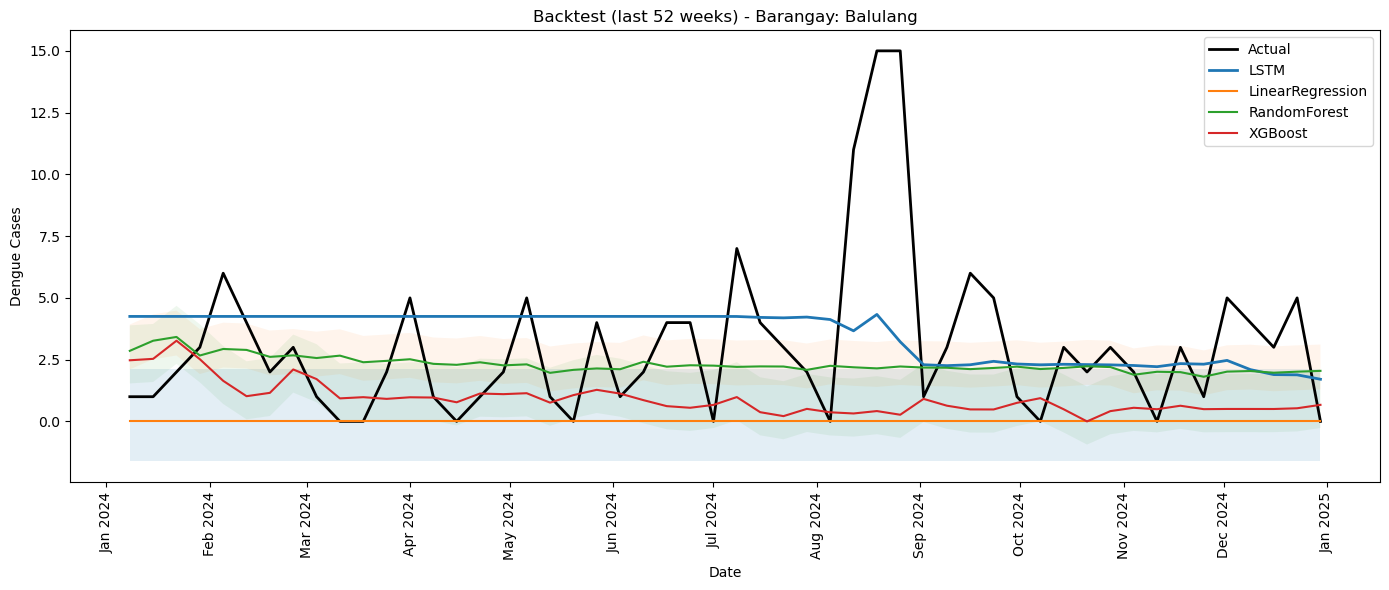

In [19]:
# Plot example barangay
plot_bgy = "Balulang"
if plot_bgy:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(actuals_pivot.index, actuals_pivot[plot_bgy], label="Actual", linewidth=2, linestyle="-", color="black")
    
    # LSTM
    ax.plot(lstm_forecast_df.index, lstm_forecast_df[plot_bgy], label="LSTM", linewidth=2)
    
    # LR
    ax.plot(tabular_forecast_dfs["LinearRegression"].index, tabular_forecast_dfs["LinearRegression"][plot_bgy], label="LinearRegression", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["LinearRegression"].index,
                    lr_lower_df[plot_bgy], lr_upper_df[plot_bgy], alpha=0.12)
    
    # RF
    ax.plot(tabular_forecast_dfs["RandomForest"].index, tabular_forecast_dfs["RandomForest"][plot_bgy], label="RandomForest", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["RandomForest"].index,
                    rf_lower_df[plot_bgy], rf_upper_df[plot_bgy], alpha=0.08)
    
    # XGB
    ax.plot(tabular_forecast_dfs["XGBoost"].index, tabular_forecast_dfs["XGBoost"][plot_bgy], label="XGBoost", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["XGBoost"].index,
                    xgb_lower_df[plot_bgy], xgb_upper_df[plot_bgy], alpha=0.08)

    ax.set_title(f"Backtest (last {BACKTEST_STEPS} weeks) - Barangay: {plot_bgy}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Dengue Cases")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.xticks(rotation=90)
    ax.legend()
    plt.tight_layout()

    # Save the figure
    save_path = f"../results/backtest_{plot_bgy}.png"
    fig.savefig(save_path, dpi=300)
    print(f"[INFO] Figure saved to {save_path}")
    
    plt.show()
else:
    print("[WARN] No barangay to plot.")

[INFO] Figure saved to ../results/backtest_Carmen.png


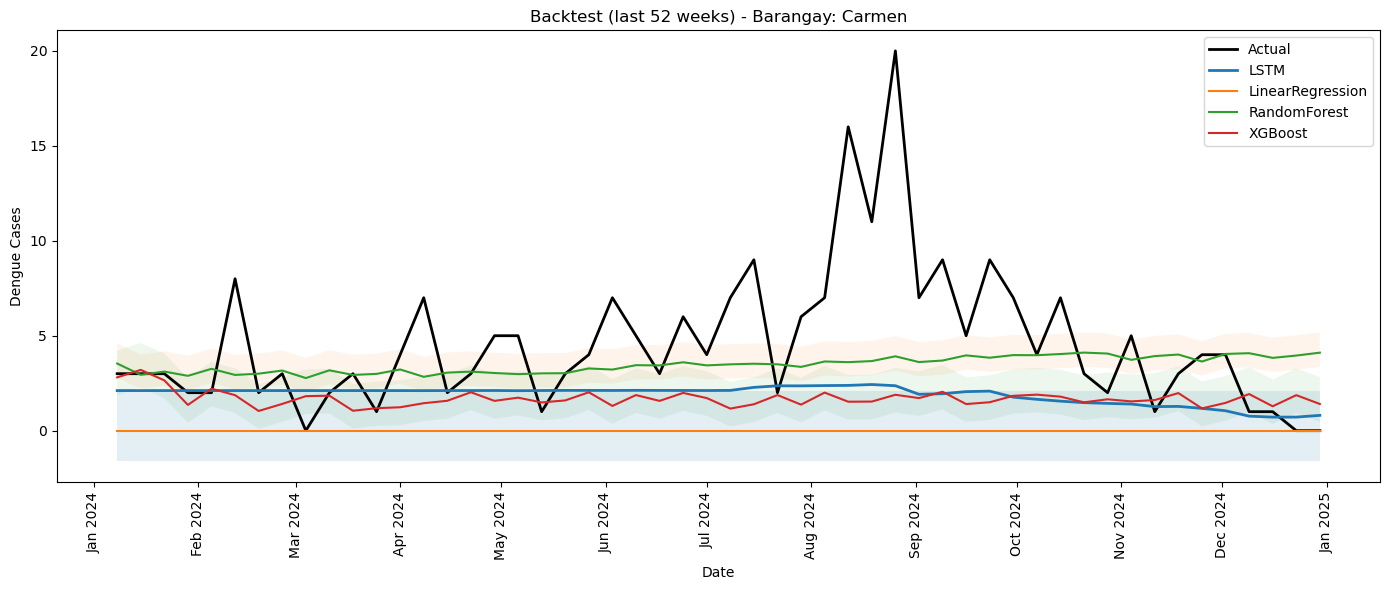

In [20]:
# Plot example barangay
plot_bgy = "Carmen"
if plot_bgy:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(actuals_pivot.index, actuals_pivot[plot_bgy], label="Actual", linewidth=2, linestyle="-", color="black")
    
    # LSTM
    ax.plot(lstm_forecast_df.index, lstm_forecast_df[plot_bgy], label="LSTM", linewidth=2)
    
    # LR
    ax.plot(tabular_forecast_dfs["LinearRegression"].index, tabular_forecast_dfs["LinearRegression"][plot_bgy], label="LinearRegression", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["LinearRegression"].index,
                    lr_lower_df[plot_bgy], lr_upper_df[plot_bgy], alpha=0.12)
    
    # RF
    ax.plot(tabular_forecast_dfs["RandomForest"].index, tabular_forecast_dfs["RandomForest"][plot_bgy], label="RandomForest", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["RandomForest"].index,
                    rf_lower_df[plot_bgy], rf_upper_df[plot_bgy], alpha=0.08)
    
    # XGB
    ax.plot(tabular_forecast_dfs["XGBoost"].index, tabular_forecast_dfs["XGBoost"][plot_bgy], label="XGBoost", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["XGBoost"].index,
                    xgb_lower_df[plot_bgy], xgb_upper_df[plot_bgy], alpha=0.08)

    ax.set_title(f"Backtest (last {BACKTEST_STEPS} weeks) - Barangay: {plot_bgy}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Dengue Cases")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.xticks(rotation=90)
    ax.legend()
    plt.tight_layout()

    # Save the figure
    save_path = f"../results/backtest_{plot_bgy}.png"
    fig.savefig(save_path, dpi=300)
    print(f"[INFO] Figure saved to {save_path}")
    
    plt.show()
else:
    print("[WARN] No barangay to plot.")

[INFO] Figure saved to ../results/backtest_Gusa.png


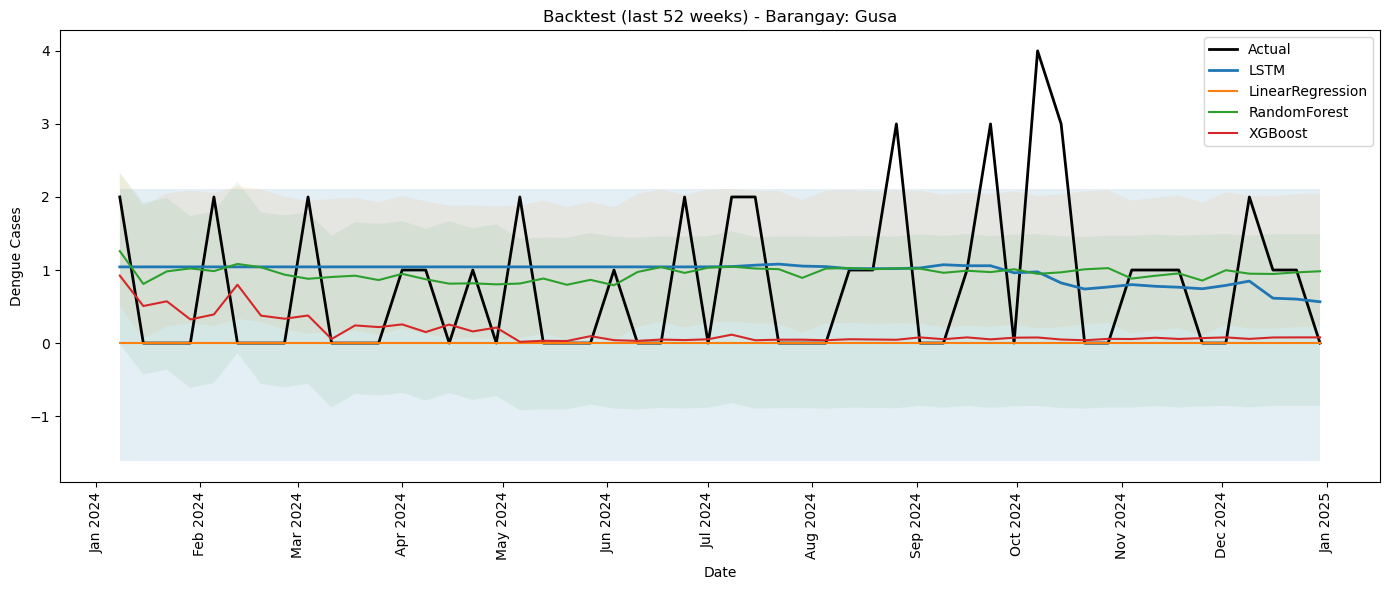

In [21]:
# Plot example barangay
plot_bgy = "Gusa"
if plot_bgy:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(actuals_pivot.index, actuals_pivot[plot_bgy], label="Actual", linewidth=2, linestyle="-", color="black")
    
    # LSTM
    ax.plot(lstm_forecast_df.index, lstm_forecast_df[plot_bgy], label="LSTM", linewidth=2)
    
    # LR
    ax.plot(tabular_forecast_dfs["LinearRegression"].index, tabular_forecast_dfs["LinearRegression"][plot_bgy], label="LinearRegression", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["LinearRegression"].index,
                    lr_lower_df[plot_bgy], lr_upper_df[plot_bgy], alpha=0.12)
    
    # RF
    ax.plot(tabular_forecast_dfs["RandomForest"].index, tabular_forecast_dfs["RandomForest"][plot_bgy], label="RandomForest", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["RandomForest"].index,
                    rf_lower_df[plot_bgy], rf_upper_df[plot_bgy], alpha=0.08)
    
    # XGB
    ax.plot(tabular_forecast_dfs["XGBoost"].index, tabular_forecast_dfs["XGBoost"][plot_bgy], label="XGBoost", linewidth=1.5)
    ax.fill_between(tabular_forecast_dfs["XGBoost"].index,
                    xgb_lower_df[plot_bgy], xgb_upper_df[plot_bgy], alpha=0.08)

    ax.set_title(f"Backtest (last {BACKTEST_STEPS} weeks) - Barangay: {plot_bgy}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Dengue Cases")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.xticks(rotation=90)
    ax.legend()
    plt.tight_layout()

    # Save the figure
    save_path = f"../results/backtest_{plot_bgy}.png"
    fig.savefig(save_path, dpi=300)
    print(f"[INFO] Figure saved to {save_path}")
    
    plt.show()
else:
    print("[WARN] No barangay to plot.")

### **RESIDUAL ANALYSIS**

To evaluate the distributional properties of model prediction errors, residuals are computed for each forecasting model across all barangays and backtesting dates. For tabular models, predicted case counts are first aligned with the ground-truth dengue observations by reshaping both into consistent `(Date × Barangay)` matrices. Residuals are then calculated as the difference between predicted and observed values and flattened across all spatial and temporal dimensions to form a single error distribution per model.

For the LSTM model, an equivalent procedure is applied by aligning sequence-based forecasts with the same ground-truth matrix and aggregating residuals across all prediction points. Any missing values resulting from alignment or lag constraints are removed to ensure valid comparisons.

To assess whether model errors approximate a normal distribution, Quantile–Quantile (Q–Q) plots are generated for each model’s residuals against a theoretical normal distribution. Deviations from the 45-degree reference line indicate departures from normality, such as skewness or heavy tails, providing insight into model bias, variance structure, and the suitability of Gaussian error assumptions for downstream statistical analysis.

[INFO] Plotting Q–Q plot for LinearRegression ...


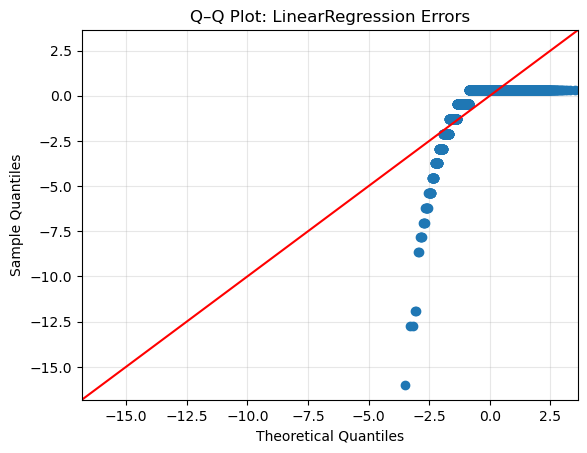

[INFO] Plotting Q–Q plot for RandomForest ...


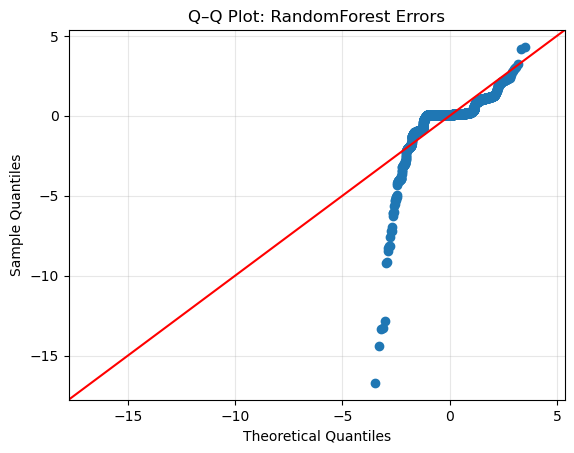

[INFO] Plotting Q–Q plot for XGBoost ...


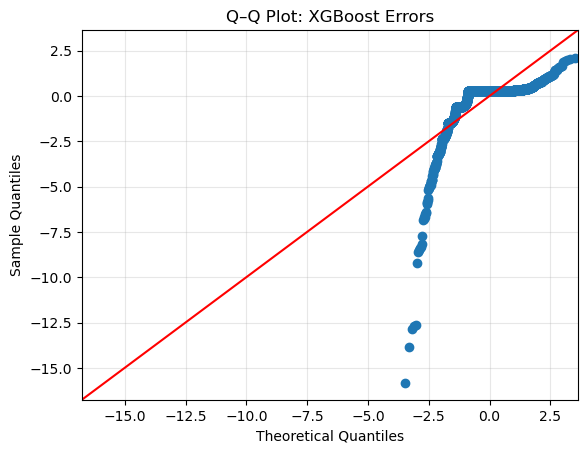

[INFO] Plotting Q–Q plot for LSTM ...


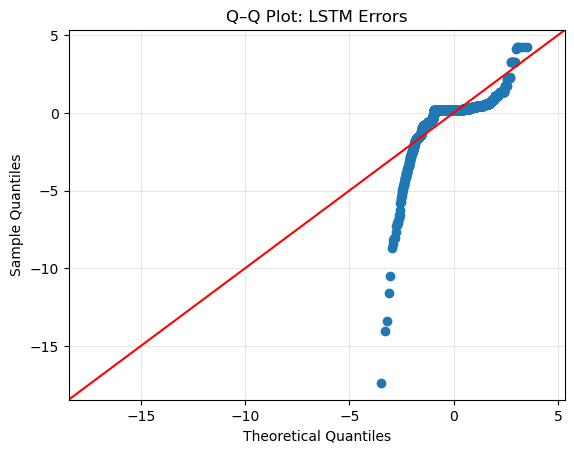

In [22]:
# Collect errors for each model
error_distributions = {}

for mname, df_pred in tabular_forecast_dfs.items():
    # Align forecasts with test values
    df_true = (
        test_df[test_df["Date"].isin(backtest_dates)]
        .pivot(index="Date", columns="Barangay", values="Cases")
        .reindex(index=backtest_dates, columns=barangays)
    )
    
    errors = (df_pred - df_true).values.flatten()  # flatten all barangays + dates
    errors = errors[~np.isnan(errors)]
    
    error_distributions[mname] = errors

# LSTM errors
df_true = (
    test_df[test_df["Date"].isin(backtest_dates)]
    .pivot(index="Date", columns="Barangay", values="Cases")
    .reindex(index=backtest_dates, columns=barangays)
)

lstm_errors = (lstm_forecast_df - df_true).values.flatten()
lstm_errors = lstm_errors[~np.isnan(lstm_errors)]
error_distributions["LSTM"] = lstm_errors

def plot_qq(errors, title):
    fig = sm.qqplot(errors, line='45', fit=True)
    plt.title(f"Q–Q Plot: {title} Errors")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True, alpha=0.3)
    plt.show()

for model_name, errs in error_distributions.items():
    print(f"[INFO] Plotting Q–Q plot for {model_name} ...")
    plot_qq(errs, model_name)

The non-normal, heavy-tailed residual patterns observed across all models are expected and consistent with prior dengue forecasting literature. Dengue case counts are inherently overdispersed, temporally irregular, and prone to sudden localized outbreaks, all of which naturally give rise to heavy-tailed and asymmetric error distributions across modeling approaches. Such behavior is therefore not indicative of model misspecification.

Importantly, most of the models employed in this study—including Random Forest, XGBoost, and the LSTM—do not rely on the assumption of normally distributed residuals for either training or inference. Consequently, deviations from normality observed in the Q–Q plots do not undermine the validity of the predictive results. Instead, they reflect the intrinsic stochasticity and burst-driven dynamics of dengue transmission.

The use of a unified city-level modeling framework was a deliberate design choice motivated by scalability, operational simplicity, and real-time deployment requirements of the Denvue platform. While barangay-level outbreaks may differ substantially in timing and magnitude, training a shared model inevitably smooths some localized variation, contributing to the observed residual structure.

Finally, it is important to emphasize that Denvue’s primary objective is not the precise estimation of barangay-level case counts. Rather, the system functions as an early-warning and decision-support tool designed to detect risk escalation, emerging trends, and potential outbreak conditions. The observed error distributions therefore reflect the fundamental uncertainty of dengue transmission, which is explicitly incorporated into the system through population-normalized incidence metrics, WHO-aligned risk tiers, and probabilistic alerting mechanisms.

### **MULTI-STEP FORECASTING**

This stage extends the dengue forecasting models to predict 104 weeks (2 years) into the future, covering 2025–2026. It generates forecasts for each barangay using multiple tabular regression models and a global LSTM model, followed by a unified WHO-based risk scoring and export process.

**Forecast Horizon Setup**

Defines a 2-year weekly horizon starting one week after the latest observed date in the dataset. A sequence of future weekly timestamps is constructed, and barangay-level historical data structures (grp_hist) are initialized using past dengue case counts and weather variables.

Models included:

* Linear Regression
* Random Forest
* XGBoost
* LSTM (global sequence model)

**Recursive Forecasting for Tabular Models**

Each tabular model performs recursive multi-step forecasting independently for every barangay:

* Lagged dengue and weather features (e.g., `Cases_lagX`, `Humidity_lagX`, `Temperature_lagX`) are generated to serve as autoregressive inputs.
* For each future timestep, the most recent predicted values are fed back into the feature set, simulating an expanding forecast window.
* Predictions are generated sequentially, ensuring temporal dependency across weeks.
* Outputs are stored as barangay-level time series and later combined into forecast matrices (dates × barangays) per model.
* An approximate confidence score is computed based on normalized deviation from the forecast mean.

**LSTM Forecast (Global)**

* A global LSTM model is trained on the full dataset using lagged dengue cases, lagged weather features, and one-hot encoded barangay identifiers.
* During forecasting, the LSTM performs recursive sequence prediction per barangay, using the most recent historical window as input.
* The model outputs weekly dengue case forecasts for each barangay over the full horizon.
* Confidence scores are estimated using inverse normalized deviation from the predicted mean.
* Results are aggregated into global forecast and confidence DataFrames.

**Combined Forecast Compilation**

All forecasts from tabular and LSTM models are merged into a unified long-format structure:

* Columns: `Date`, `Barangay`, `Model`, `Forecast_Cases`, and `Confidence`
* Forecasts are rounded to integer case counts
* Data are sorted chronologically and by barangay
* The consolidated DataFrame serves as the input for downstream risk analysis and export

---

**Risk Scoring (WHO-Based, Population-Normalized)**

Each barangay’s forecasted dengue burden is translated into a public-health–aligned risk category using population-adjusted incidence rates.

The Barangay Risk Level reflects projected dengue incidence per population rather than absolute case counts. This ensures that risk is comparable across barangays of different sizes and aligns with international epidemiological standards. The approach mirrors incidence-based monitoring used in global surveillance reports (often reported per 100,000 population), adapted here for finer local granularity and validated in Philippine and regional modeling studies. It effectively flags sharp increases in smaller barangays, supporting scalable early-warning systems and targeted interventions consistent with established public health frameworks.

Forecasted cases are normalized using barangay population to compute **incidence per 10,000 residents**.

Risk levels are assigned using fixed WHO-style thresholds:

* **Low Risk:** ≤ 5 cases per 10,000
* **Moderate Risk:** > 5 and ≤ 15 cases per 10,000
* **High Risk:** > 15 and ≤ 30 cases per 10,000
* **Critical Risk:** > 30 cases per 10,000

A small, controlled stochastic perturbation is applied to forecasts with low variance to avoid artificially flat trajectories, after which incidence and risk levels are recomputed. This preserves temporal realism while maintaining epidemiological validity.

---

**Geographic Data Export**

* Converts the Cagayan de Oro barangay shapefile (`PH_Adm4_BgySubMuns.shp`) into a CSV file containing barangay names and corresponding WKT geometries.
* The coordinate reference system (CRS) is standardized to EPSG:4326 (latitude–longitude) to ensure compatibility with web-based mapping tools.
* The resulting file is saved as `cdo_barangays.csv` in the results directory and used for spatial risk visualization and dashboard integration.

In [23]:
print("[INFO] Final model training ...")

X_tab = df_lagged[feature_cols]
y_tab = df_lagged[target_col]


# Linear Regression
print("[INFO] Training Linear Regression on full dataset ...")

scaler_tab = StandardScaler()
X_scaled = scaler_tab.fit_transform(X_tab)
dump(scaler_tab, os.path.join(MODEL_DIR, "tabular_scaler.joblib"))

lr_final = LinearRegression()
lr_final.fit(X_scaled, y_tab)
ensure_dir(os.path.join(MODEL_DIR, "linear_regression"))
dump(lr_final, os.path.join(MODEL_DIR, "linear_regression", "model.joblib"))


# Random Forest
print("[INFO] Training Random Forest on full dataset ...")
rf_final = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features="sqrt",
    max_depth=None,
    random_state=SEED,
    n_jobs=-1
)
rf_final.fit(X_tab, y_tab)
ensure_dir(os.path.join(MODEL_DIR, "random_forest"))
dump(rf_final, os.path.join(MODEL_DIR, "random_forest", "model.joblib"))


# XGBoost
print("[INFO] Training XGBoost on full dataset ...")
xgb_final = XGBRegressor(
    subsample=0.8,
    reg_lambda=1,
    reg_alpha=0.01,
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.6,
    random_state=SEED,
    objective="reg:squarederror",
    verbosity=0,
    n_jobs=-1
)
xgb_final.fit(X_tab, y_tab)
ensure_dir(os.path.join(MODEL_DIR, "xgboost"))
dump(xgb_final, os.path.join(MODEL_DIR, "xgboost", "model.joblib"))


# LSTM
print("[INFO] Training LSTM on full dataset ...")
X_lstm_full, y_lstm_full = to_lstm_sequence(
    df_lagged,
    lookback=LOOKBACK,
    lag_cols=lag_cols,
    weather_lag_cols=weather_lag_cols,
    barangay_cols=barangay_dummy_cols,
    target_col=target_col
)

n_timesteps = X_lstm_full.shape[1]
n_features = X_lstm_full.shape[2]

lstm_final = Sequential([
    LSTM(64, return_sequences=False, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

lstm_final.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"]
)

lstm_final.fit(
    X_lstm_full,
    y_lstm_full,
    epochs=50,
    batch_size=32,
    verbose=0
)

lstm_dir = os.path.join(MODEL_DIR, "lstm")
ensure_dir(lstm_dir)
lstm_final.save(os.path.join(lstm_dir, "model.keras"))

[INFO] Final model training ...
[INFO] Training Linear Regression on full dataset ...
[INFO] Training Random Forest on full dataset ...
[INFO] Training XGBoost on full dataset ...
[INFO] Training LSTM on full dataset ...


In [24]:
print("[INFO] Starting multi-step forecasts for 2025–2026 ...")

# Forecast horizon: 2 years = 104 weeks
future_steps = 104
future_dates = pd.date_range(
    start=df["Date"].max() + pd.Timedelta(weeks=1),
    periods=future_steps,
    freq="W-MON"
)

# Initialize per-barangay histories
grp_hist = {b: g.sort_values("Date").set_index("Date").copy() 
            for b, g in df.groupby("Barangay", sort=False)}
barangays = list(grp_hist.keys())

# Define tabular models for recursion
models_to_run = {
    "linear_regression": (lr_final, True),
    "random_forest": (rf_final, False),
    "xgboost": (xgb_final, False),
}

tabular_forecasts = {m: [] for m in models_to_run}    # store forecast per model
tabular_confidences = {m: [] for m in models_to_run}  # store confidence per model


print("[INFO] Running multi-step recursive forecasts for tabular models ...")

for b in barangays:
    hist = grp_hist[b].copy()

    # Ensure lag columns exist
    for lag in LAGS:
        hist[f"Cases_lag{lag}"] = hist["Cases"].shift(lag)
    for w in WEATHER_COLS:
        for lag in WEATHER_LAGS:
            hist[f"{w}_lag{lag}"] = hist[w].shift(lag)
    hist = hist.fillna(0)

    for mname, (mdl, scaled_flag) in models_to_run.items():
        try:
            s = recursive_tabular_forecast(
                model=mdl,
                model_name=mname,
                start_hist=hist,
                future_dates=future_dates,
                lags=LAGS,
                weather_lags=WEATHER_LAGS,
                feature_cols=feature_cols,
                scaler_for_lr=(scaler_tab if scaled_flag else None),
                test_df_for_exog=None,
                barangay_dummy_cols=barangay_dummy_cols,
                stochastic_std=0.2,
                random_state=SEED
            )
            s.name = b
            tabular_forecasts[mname].append(s)

            # Approximate confidence: smaller variance = higher confidence
            # Normalize so confidence ∈ [0,1]
            conf = 1 - (np.abs(s - s.mean()) / (s.abs().mean() + 1e-6))
            conf = conf.clip(0, 1)
            conf.name = b
            tabular_confidences[mname].append(conf)

        except Exception as e:
            print(f"[WARN] forecast failed for barangay {b} model {mname}: {e}")

# Combine per-model forecasts into DataFrames (dates × barangays)
tabular_forecast_dfs = {}
tabular_conf_df = {}

for mname, series_list in tabular_forecasts.items():
    if len(series_list) == 0:
        dfm = pd.DataFrame(index=future_dates, columns=barangays).fillna(0.0)
        confm = dfm.copy()
    else:
        dfm = pd.concat(series_list, axis=1)
        confm = pd.concat(tabular_confidences[mname], axis=1)
        dfm.columns = confm.columns = [s.name for s in series_list]
        dfm = dfm.reindex(columns=barangays).fillna(0.0)
        confm = confm.reindex(columns=barangays).fillna(0.0)
    tabular_forecast_dfs[mname] = dfm
    tabular_conf_df[mname] = confm

print("[INFO] Tabular forecasts completed.")


# LSTM Forecast (global)

print("[INFO] Forecasting using LSTM model ...")

lstm_forecasts = []
lstm_confidences = []

for b in barangays:
    hist = grp_hist[b].copy()

    # Add static barangay dummy columns
    for col in barangay_dummy_cols:
        hist[col] = 0.0
    baseline = f"Barangay_{b}"
    if baseline in barangay_dummy_cols:
        hist[baseline] = 1.0

    # Add lag features
    for lag in LAGS:
        hist[f"Cases_lag{lag}"] = hist["Cases"].shift(lag)
    for w in WEATHER_COLS:
        for lag in WEATHER_LAGS:
            hist[f"{w}_lag{lag}"] = hist[w].shift(lag)

    hist = hist.fillna(method="ffill").fillna(0)

    try:
        s = recursive_lstm_forecast(
            model=lstm_final,
            start_hist=hist,
            future_dates=future_dates,
            lookback=LOOKBACK,
            lag_cols=lag_cols,
            weather_lag_cols=weather_lag_cols,
            barangay_dummy_cols=barangay_dummy_cols,
            weather_cols=WEATHER_COLS
        )
        s.name = b
        lstm_forecasts.append(s)

        # Confidence: inverse deviation from mean
        conf = 1 - (np.abs(s - s.mean()) / (s.abs().mean() + 1e-6))
        conf = conf.clip(0, 1)
        conf.name = b
        lstm_confidences.append(conf)

    except Exception as e:
        print(f"[WARN] LSTM forecast failed for barangay {b}: {e}")


# Combine LSTM forecasts
if len(lstm_forecasts) == 0:
    lstm_forecast_df = pd.DataFrame(index=future_dates, columns=barangays).fillna(0.0)
    lstm_conf_df = lstm_forecast_df.copy()
else:
    lstm_forecast_df = pd.concat(lstm_forecasts, axis=1)
    lstm_conf_df = pd.concat(lstm_confidences, axis=1)
    lstm_forecast_df.columns = lstm_conf_df.columns = [s.name for s in lstm_forecasts]
    lstm_forecast_df = lstm_forecast_df.reindex(columns=barangays).fillna(0.0)
    lstm_conf_df = lstm_conf_df.reindex(columns=barangays).fillna(0.0)

print("[INFO] LSTM forecasts completed.")


print("[INFO] Combining all forecasts ...")

all_forecasts = []

# Tabular models
for model_name, df_model in tabular_forecast_dfs.items():
    df_conf = tabular_conf_df[model_name]
    df_long = df_model.reset_index().melt(id_vars="index", 
                                         var_name="Barangay", 
                                         value_name="Forecast_Cases")
    df_conf_long = df_conf.reset_index().melt(id_vars="index", 
                                             var_name="Barangay", 
                                             value_name="Confidence")

    df_merged = pd.merge(df_long, df_conf_long, on=["index", "Barangay"])
    df_merged = df_merged.rename(columns={"index": "Date"})
    df_merged["Model"] = model_name
    df_merged["Forecast_Cases"] = df_merged["Forecast_Cases"].round().astype(int)

    all_forecasts.extend(df_merged.to_dict(orient="records"))

# LSTM
lstm_long = lstm_forecast_df.reset_index().melt(id_vars="index",
                                                var_name="Barangay",
                                                value_name="Forecast_Cases")
lstm_conf_long = lstm_conf_df.reset_index().melt(id_vars="index",
                                                var_name="Barangay",
                                                value_name="Confidence")

lstm_merged = pd.merge(lstm_long, lstm_conf_long, on=["index", "Barangay"])
lstm_merged = lstm_merged.rename(columns={"index": "Date"})
lstm_merged["Model"] = "lstm"
lstm_merged["Forecast_Cases"] = lstm_merged["Forecast_Cases"].round().astype(int)

all_forecasts.extend(lstm_merged.to_dict(orient="records"))

forecast_df = pd.DataFrame(all_forecasts)
forecast_df = forecast_df.sort_values(["Barangay", "Model", "Date"]).reset_index(drop=True)

print("[INFO] Multi-step forecasts for 2025–2026 completed successfully.")

[INFO] Starting multi-step forecasts for 2025–2026 ...
[INFO] Running multi-step recursive forecasts for tabular models ...
[INFO] Tabular forecasts completed.
[INFO] Forecasting using LSTM model ...
[INFO] LSTM forecasts completed.
[INFO] Combining all forecasts ...
[INFO] Multi-step forecasts for 2025–2026 completed successfully.


In [ ]:
print("[INFO] Applying risk scoring and exporting results ...")

# Ensure non-negative forecasts
forecast_df["Forecast_Cases"] = forecast_df["Forecast_Cases"].clip(lower=0)

# Attach population per barangay
barangay_pop = (
    df[["Barangay", "Population"]]
    .drop_duplicates("Barangay")
)

forecast_df = forecast_df.merge(
    barangay_pop,
    on="Barangay",
    how="left"
)

# Ensure Population is numeric
forecast_df["Population"] = (
    forecast_df["Population"]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(float)
)

# Compute population-normalized incidence (cases per 10,000 people)
forecast_df["Incidence_10k"] = (
    forecast_df["Forecast_Cases"] / forecast_df["Population"].clip(lower=1)
) * 10_000

# WHO incidence thresholds (cases per 10,000 population)
WHO_THRESHOLDS = {
    "Low": 5,
    "Moderate": 15,
    "High": 30,
}

# Risk Scoring with controlled stochastic adjustment
risk_dfs = []

for model_name, group_model in forecast_df.groupby("Model", sort=False):
    df_model = group_model.copy()

    # Barangay-level risk assignment function (WHO-based)
    def assign_risk(row):
        val = row["Incidence_10k"]
        if val <= WHO_THRESHOLDS["Low"]:
            return "Low"
        elif val <= WHO_THRESHOLDS["Moderate"]:
            return "Moderate"
        elif val <= WHO_THRESHOLDS["High"]:
            return "High"
        else:
            return "Critical"

    df_model["Risk_Level"] = None
    rng = np.random.default_rng(seed=SEED)

    for b, g in df_model.groupby("Barangay", sort=False):
        vals = g["Incidence_10k"].values.astype(float)

        # Skip if all zeros
        if np.all(vals == 0):
            df_model.loc[df_model["Barangay"] == b, "Risk_Level"] = "Low"
            continue

        mask = df_model["Barangay"] == b
        adjusted_vals = df_model.loc[mask, "Forecast_Cases"].values

        # Add small stochastic noise only if variance is low
        val_std = np.std(adjusted_vals)
        val_mean = np.mean(adjusted_vals) + 1e-6
        stochastic_factor = min(0.05 + 0.10 * np.exp(-val_std / val_mean), 0.12)

        noise = rng.normal(0, stochastic_factor * np.maximum(adjusted_vals, 1.0))
        noisy_vals = np.clip(adjusted_vals + noise, 0, None)

        # Update forecasts and recompute incidence
        df_model.loc[mask, "Forecast_Cases"] = noisy_vals
        df_model.loc[mask, "Incidence_10k"] = (
            noisy_vals / df_model.loc[mask, "Population"].clip(lower=1)
        ) * 10_000

        df_model.loc[mask, "Risk_Level"] = df_model.loc[mask].apply(
            assign_risk, axis=1
        )

    # Round forecasts after risk classification
    df_model["Forecast_Cases"] = df_model["Forecast_Cases"].round().astype(int)

    # Sort & save per model
    df_model = df_model.sort_values(["Barangay", "Date"]).reset_index(drop=True)
    csv_path = f"{model_name}_forecasts.csv"
    df_model.to_csv(f"{RESULTS_DIR}/{csv_path}", index=False)
    print(f"[INFO] Saved {model_name} forecasts with risk scores to {csv_path}.")

    risk_dfs.append(df_model)

# Combine all models
forecast_with_risk = pd.concat(risk_dfs, ignore_index=True)
forecast_with_risk = forecast_with_risk.sort_values(
    ["Barangay", "Model", "Date"]
).reset_index(drop=True)

# Save full combined CSV too
forecast_with_risk.to_csv(f"{RESULTS_DIR}/all_models_forecasts.csv", index=False)
print("[INFO] Combined forecast with risk scores saved.")
display(forecast_with_risk)

[INFO] Applying risk scoring and exporting results ...
[INFO] Saved linear_regression forecasts with risk scores to linear_regression_forecasts.csv.
[INFO] Saved lstm forecasts with risk scores to lstm_forecasts.csv.
[INFO] Saved random_forest forecasts with risk scores to random_forest_forecasts.csv.
[INFO] Saved xgboost forecasts with risk scores to xgboost_forecasts.csv.
[INFO] Combined forecast with risk scores saved.


,Date,Barangay,Forecast_Cases,Confidence,Model,Population,Incidence_10k,Risk_Level
0,2025-01-06,Agusan,0,0.993312,linear_regression,19039.0,0.0,Low
1,2025-01-13,Agusan,0,0.000017,linear_regression,19039.0,0.0,Low
2,2025-01-20,Agusan,0,0.000000,linear_regression,19039.0,0.0,Low
3,2025-01-27,Agusan,0,0.000000,linear_regression,19039.0,0.0,Low
4,2025-02-03,Agusan,0,0.000017,linear_regression,19039.0,0.0,Low
...,...,...,...,...,...,...,...,...
33275,2026-11-30,Tumpagon,0,0.000016,xgboost,2305.0,0.0,Low
33276,2026-12-07,Tumpagon,0,0.000016,xgboost,2305.0,0.0,Low
33277,2026-12-14,Tumpagon,0,0.000000,xgboost,2305.0,0.0,Low
33278,2026-12-21,Tumpagon,0,0.000016,xgboost,2305.0,0.0,Low


In [26]:
print("[INFO] Converting CDO barangays shapefile to CSV ...")

# Load shapefile
ph_barangays = gpd.read_file("../data/raw/PH_Adm4_BgySubMuns.zip")

# Filter to Cagayan de Oro (adm3_psgc = 1030500000)
cdo_barangays = ph_barangays[ph_barangays['adm3_psgc'] == 1030500000].copy()
cdo_barangays = cdo_barangays[['adm4_en', 'geometry']].rename(columns={'adm4_en': 'Barangay'})

# Convert CRS to EPSG:4326 (latitude-longitude)
cdo_barangays = cdo_barangays.to_crs(epsg=4326)

# Convert geometry to WKT for CSV saving
cdo_barangays['Geometry'] = cdo_barangays['geometry'].apply(lambda g: g.wkt)
cdo_barangays = cdo_barangays.drop(columns='geometry')

# Save as CSV
output_path = "cdo_barangays.csv"
cdo_barangays.to_csv(f"{RESULTS_DIR}/{output_path}", index=False)
print(f"[INFO] Saved barangay geometries to {output_path}")

[INFO] Converting CDO barangays shapefile to CSV ...
[INFO] Saved barangay geometries to cdo_barangays.csv
